In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.lines import Line2D
import math
import random
## USES CSV CREATED FROM ANALYSIS_PROJECTION.

thresholds = np.arange(0.2, 0.7, 0.05)
thresholds = np.round(thresholds, 2)

dfs = [pd.read_csv(f"All_models_threshold_{thresh}_ERA5comp.csv") for thresh in thresholds]
for thresh, df in zip(thresholds, dfs):
    print(f"{thresh:.2f}: rows = {len(df)}")
meta_cols = ['model', 'experiment', 'member', 'node', 'period']
num_cols = ['slope_days_per_decade', 'p_value']

# Average only the numeric columns
avg_df = dfs[0][meta_cols].copy()
avg_df[num_cols] = sum(df[num_cols] for df in dfs) / len(dfs)

# Handle the bovg_df[num_cols] = sum(df[num_cols] for df in dfs) / len(dfs)olean “significant” column — e.g., True if majority are True
sign_cols = [df['significant'] for df in dfs]
avg_df['significant'] = sum(sign_cols) >= (len(dfs) / 2)

print(avg_df)

0.20: rows = 2160
0.25: rows = 2160
0.30: rows = 2160
0.35: rows = 2160
0.40: rows = 2160
0.45: rows = 2160
0.50: rows = 2160
0.55: rows = 2160
0.60: rows = 2160
0.65: rows = 2160
           model  experiment  member  node     period  slope_days_per_decade  \
0     NorESM2-LM  historical       1     0  1940-1979               0.082884   
1     NorESM2-LM  historical       1     0  1980-2014              -0.389377   
2     NorESM2-LM  historical       1     1  1940-1979               0.132801   
3     NorESM2-LM  historical       1     1  1980-2014              -1.468316   
4     NorESM2-LM  historical       1     2  1940-1979               0.583846   
...          ...         ...     ...   ...        ...                    ...   
2155        ERA5        ERA5       1     1  1980-2014               0.520757   
2156        ERA5        ERA5       1     2  1940-1979               0.174584   
2157        ERA5        ERA5       1     2  1980-2014               0.050991   
2158        ERA5    

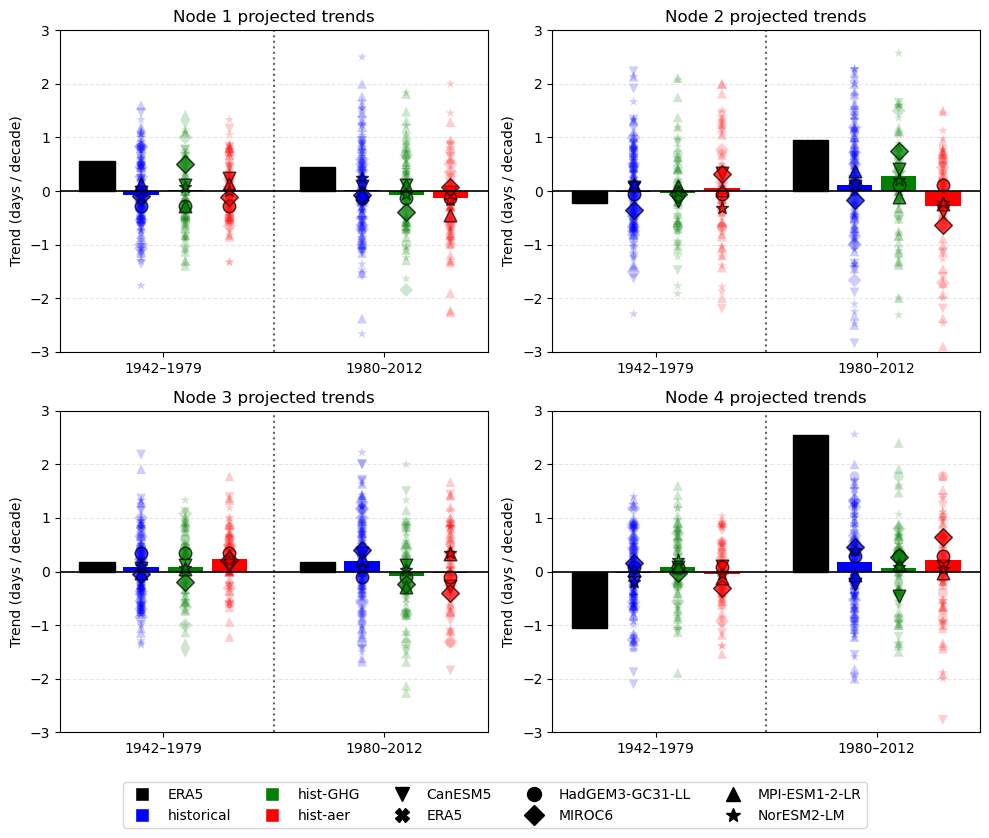

In [4]:
# ---------- user settings (edit if you want) ----------
csv_path = "All_models_threshold_0.4_ERA5comp.csv"

models = ['NorESM2-LM','CanESM5', 'MPI-ESM1-2-LR', 'HadGEM3-GC31-LL', 'MIROC6']  # used for legend order / emphasis
experiments = ['historical', 'hist-GHG', 'hist-aer']
colors = {"ERA5": "black", "historical": "blue", "hist-GHG": "green", "hist-aer": "red"}
periods = ["1940-1979", "1980-2014"]
custom_labels = {"1940-1979": "1942–1979", "1980-2014": "1980–2012"}
MARKERS = {
    "HadGEM3-GC31-LL": "o", "ERA5": "X", "CMCC-CM2-SR5": "s",
    "MPI-ESM1-2-LR": "^", "MIROC6": "D", "CanESM5": "v",
    "ACCESS-ESM1-5": "P", "NorESM2-LM": "*"
}

n_boot = 1000
random_seed = 42
plot_members = True
# ------------------------------------------------------

# Read CSV
df = pd.read_csv(csv_path)
#df = avg_df

# 1) Average over members for each model-experiment-node-period
# This produces one slope per (model, experiment, node, period)
df_mean = (
    df
    .groupby(['model', 'experiment', 'node', 'period'], as_index=False)
    ['slope_days_per_decade']
    .mean()
    .rename(columns={'slope_days_per_decade': 'mean_slope'})
)

# Build convenient lookup: results[model][exp][period][node] -> value
unique_models = sorted(df_mean['model'].unique())
node_order = sorted(df_mean['node'].unique())
results = {}
for m in unique_models:
    results[m] = {}
    for exp in df_mean.loc[df_mean['model'] == m, 'experiment'].unique():
        results[m][exp] = {}
        for p in periods:
            # create dict node -> slope (if missing, NaN)
            rows = df_mean[(df_mean['model'] == m) &
                           (df_mean['experiment'] == exp) &
                           (df_mean['period'] == p)]
            node_map = {int(r.node): float(r.mean_slope) for r in rows.itertuples(index=False)}
            # ensure all nodes present
            for n in node_order:
                node_map.setdefault(n, np.nan)
            results[m][exp][f"mean_trend_{p}"] = node_map

# 2) ERA5 trends per period-node
era5_trends = {p: {n: np.nan for n in node_order} for p in periods}
if 'ERA5' in results and 'ERA5' in df_mean['experiment'].unique():
    # note: in your CSV the ERA5 model seems to have experiment 'ERA5' too
    for p in periods:
        node_map = results.get('ERA5', {}).get('ERA5', {}).get(f"mean_trend_{p}", {})
        for n in node_order:
            era5_trends[p][n] = node_map.get(n, np.nan)

# 3) MMM for each experiment+period using bootstrap across models (exclude ERA5)
models_for_mmm = [m for m in unique_models if m != 'ERA5']

rng = random.Random(random_seed)
np.random.seed(random_seed)

# For quick access, build model_trends[model][(period, node)] = value
model_trends = {}
for m in models_for_mmm:
    model_trends[m] = {}
    for p in periods:
        # find experiment name(s) for this model: we expect same exp names as experiments list; we'll use the experiment names present in this model
        for exp in results[m].keys():
            # only consider exps that are in the experiments list (we want historical/hist-GHG/hist-aer)
            if exp in experiments:
                for n in node_order:
                    key = (exp, p, n)
                    val = results[m][exp].get(f"mean_trend_{p}", {}).get(n, np.nan)
                    model_trends[m][key] = val

# GET MMM
mean_by_exp = {exp: {p: {n: np.nan for n in node_order} for p in periods} for exp in experiments}

for exp in experiments:
    for p in periods:
        model_vals = []

        for m in models_for_mmm:
            vals = [model_trends.get(m, {}).get((exp, p, n), np.nan) for n in node_order]
            if not any(np.isnan(vals)):
                model_vals.append(vals)

        if not model_vals:
            continue  # skip if no valid models

        model_vals = np.array(model_vals)  # shape (n_models, n_nodes)
        mean_est = np.nanmean(model_vals, axis=0)  # equal-weighted mean across models

        for ni, n in enumerate(node_order):
            mean_by_exp[exp][p][n] = mean_est[ni]

# 4) Compute y-limits across all plotted values to keep axes consistent
all_values = []
# include MMMs
for exp in experiments:
    for p in periods:
        for n in node_order:
            v = mean_by_exp[exp][p][n]
            if not np.isnan(v):
                all_values.append(v)
# include ERA5
for p in periods:
    for n in node_order:
        v = era5_trends[p][n]
        if not np.isnan(v):
            all_values.append(v)
# include individual models (for models in 'models' if they exist, else all)
models_for_scatter = [m for m in (models + unique_models) if m in unique_models and m != 'ERA5']
for m in models_for_scatter:
    for exp in experiments:
        for p in periods:
            node_map = results[m].get(exp, {}).get(f"mean_trend_{p}", {})
            for n in node_order:
                v = node_map.get(n, np.nan)
                if not np.isnan(v):
                    all_values.append(v)

if plot_members == True:
    ymin, ymax = -2.5, 2.5
else:
    ymin, ymax = min(all_values), max(all_values)
pad = 0.1 * (ymax - ymin) if ymax > ymin else 0.1
ymin, ymax = ymin - pad, ymax + pad

# 5) Plotting: create subplots, one per node
n_nodes = 4
nrows = 2
ncols = 2

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), squeeze=False)
bar_axes = axes.flatten()[:n_nodes]

# x mapping logic: keep consistent order per period: ERA5 then experiments
order = ['ERA5'] + experiments

for i, ax in enumerate(bar_axes):
    node = node_order[i]
    # build x positions
    x_map, centers = {}, []
    for j, p in enumerate(periods):
        start = j * (len(order) + 1)
        centers.append(start + (len(order) - 1) / 2)
        for k, exp in enumerate(order):
            x_map[(exp, p)] = start + k

    # MMM bars
    for exp in experiments:
        for p in periods:
            xpos = x_map[(exp, p)]
            mean_val = mean_by_exp[exp][p][node]
            if np.isnan(mean_val):
                continue
            ax.bar(xpos, mean_val, color=colors.get(exp, "gray"), width=0.8, zorder=1, label=f"MMM {exp}" if (i==0) else "")

    # ERA5 bars
    for p in periods:
        xpos = x_map[("ERA5", p)]
        y = era5_trends[p].get(node, np.nan)
        if not np.isnan(y):
            ax.bar(xpos, y, color=colors.get("ERA5", "black"), edgecolor="black", width=0.8, zorder=3)

    # Scatter individual models (exclude ERA5)
    for m in models_for_scatter:
        for exp in experiments:
            for p in periods:
                xpos = x_map[(exp, p)]
                val = results.get(m, {}).get(exp, {}).get(f"mean_trend_{p}", {}).get(node, np.nan)
                if np.isnan(val):
                    continue
                ax.scatter(xpos, val,
                           marker=MARKERS.get(m, "o"),
                           color=colors.get(exp, "gray"),
                           edgecolor="black",
                           alpha=0.5,
                           s=80,
                           zorder=2)
                
                # Also plot per-member trends
                if plot_members:
                    members = df[(df['model'] == m) & (df['experiment'] == exp) & (df['period'] == p) & (df['node'] == node)]
                    for mv in members['slope_days_per_decade'].values:
                        if not np.isnan(mv):
                            ax.scatter(xpos, mv,
                                       marker=MARKERS.get(m, "o"),
                                       color=colors.get(exp, "gray"),
                                       edgecolor="none",
                                       alpha=0.1,
                                       s=50,
                                       zorder=1)
    
    # axis cosmetics
    ax.axhline(0, c="k", lw=1.2)
    # vertical dividers between periods
    for j in range(1, len(periods)):
        ax.axvline(j * (len(order) + 1) - 1, c="k", ls=":", alpha=0.6)

    ax.set_ylim(ymin, ymax)
    ax.set_xticks(centers)
    ax.set_xticklabels([custom_labels.get(p, p) for p in periods])
    ax.set_ylabel("Trend (days / decade)")
    ax.set_title(f"Node {node + 1} projected trends", fontsize=12)
    ax.grid(axis='y', ls='--', alpha=0.3)

# Legends
# model legend (exclude ERA5 as it's an experiment legend)
model_legend = []
for m in models_for_scatter:
    model_legend.append(
        Line2D([0], [0], marker=MARKERS.get(m, 'o'), color='w', label=m,
               markerfacecolor='black', markeredgecolor='black', markersize=8)
    )
# experiment legend (ERA5 + experiments)
model_legend = [Line2D([0], [0], marker=MARKERS[m], color='w', label=m,
                       markerfacecolor='black', markeredgecolor='black', markersize = 10)
                       for m in list(results.keys())]
exp_legend = [Line2D([0], [0], marker='s', color='w', label=e,
                     markerfacecolor=colors.get(e, 'k'), markersize = 10)
                     for e in ["ERA5"] + experiments]

fig.legend(handles=exp_legend + model_legend, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.05)) # (left/bottom, right/top)

fig.tight_layout(rect=[0, 0.03, 1, 1])  # leave space for legend
#plt.savefig('projection_plot2.png')
plt.show()



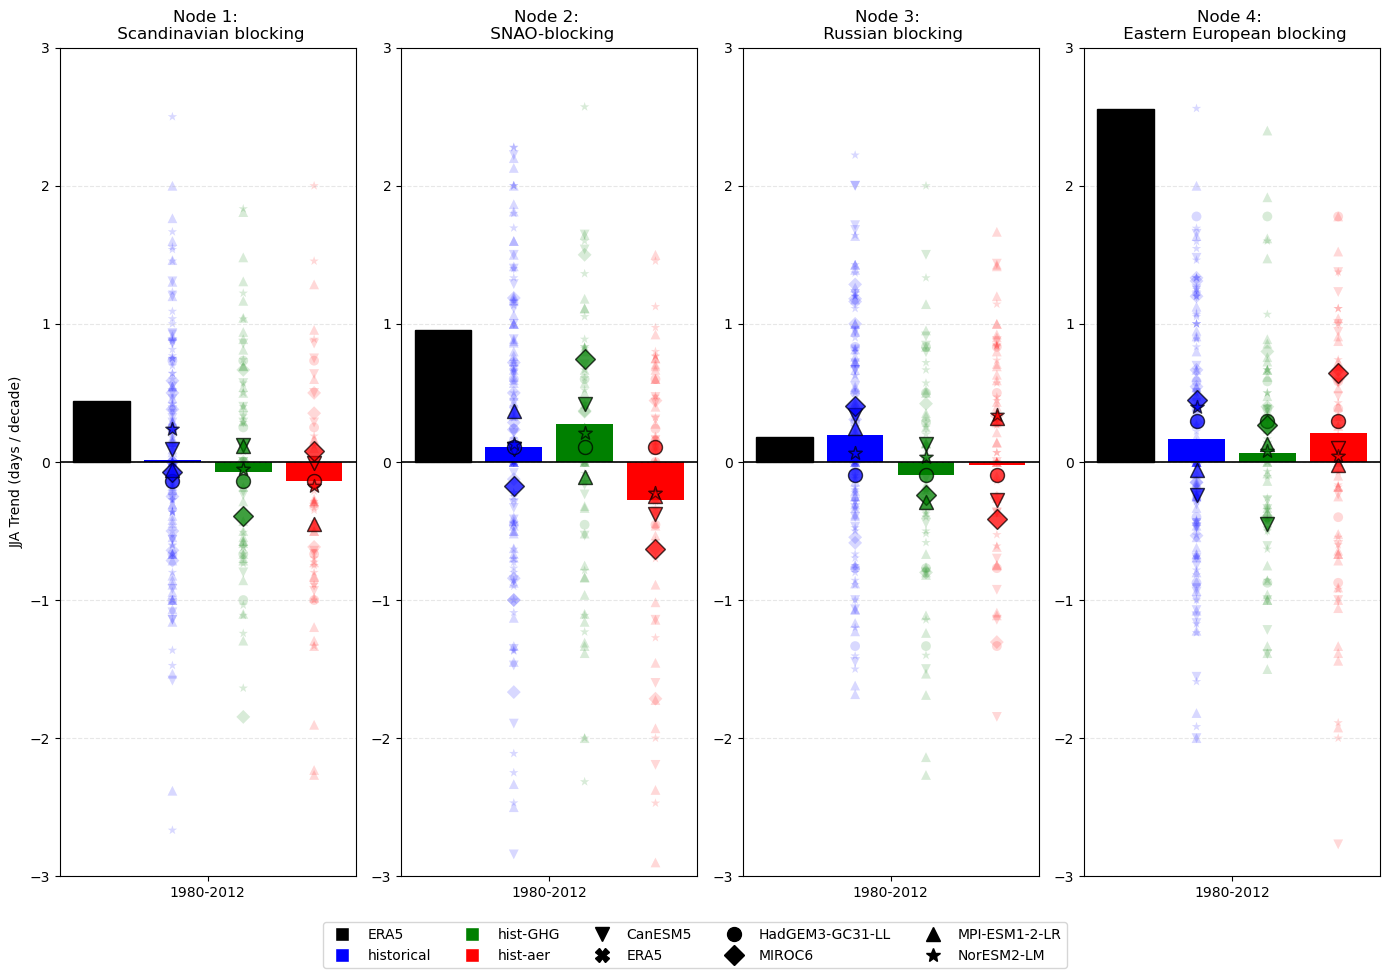

In [5]:
# --- layout: 1 row, 4 columns ---
n_nodes = 4
nrows = 1
ncols = 4
node_titles = ["Scandinavian blocking", "SNAO-blocking", "Russian blocking", "Eastern European blocking"]

# choose the latter period to plot; prefer exact '1980-2014' otherwise use last period available
preferred_latter = '1980-2014'
plot_periods = [p for p in periods if p == preferred_latter] or [periods[-1]]

fig, axes = plt.subplots(nrows, ncols, figsize=(3.5*ncols, 10*nrows), squeeze=False)
bar_axes = axes.flatten()[:n_nodes]

# x mapping logic: keep consistent order per period: ERA5 then experiments
order = ['ERA5'] + experiments

for i, ax in enumerate(bar_axes):
    node = node_order[i]
    # build x positions (only for the selected plot_periods)
    x_map, centers = {}, []
    for j, p in enumerate(plot_periods):
        start = j * (len(order) + 1)
        centers.append(start + (len(order) - 1) / 2)
        for k, exp in enumerate(order):
            x_map[(exp, p)] = start + k

    # MMM bars (experiments)
    for exp in experiments:
        for p in plot_periods:
            xpos = x_map[(exp, p)]
            mean_val = mean_by_exp[exp][p][node]
            if np.isnan(mean_val):
                continue
            ax.bar(xpos, mean_val, color=colors.get(exp, "gray"), width=0.8, zorder=1,
                   label=f"MMM {exp}" if (i == 0) else "")

    # ERA5 bars
    for p in plot_periods:
        xpos = x_map[("ERA5", p)]
        y = era5_trends[p].get(node, np.nan)
        if not np.isnan(y):
            ax.bar(xpos, y, color=colors.get("ERA5", "black"), edgecolor="black", width=0.8, zorder=3)

    # Scatter individual models (exclude ERA5)
    for m in models_for_scatter:
        for exp in experiments:
            for p in plot_periods:
                xpos = x_map[(exp, p)]
                val = results.get(m, {}).get(exp, {}).get(f"mean_trend_{p}", {}).get(node, np.nan)
                if np.isnan(val):
                    continue
                ax.scatter(xpos, val,
                           marker=MARKERS.get(m, "o"),
                           color=colors.get(exp, "gray"),
                           edgecolor="black",
                           alpha=0.5,
                           s=100,
                           zorder=2)

                # Also plot per-member trends
                if plot_members:
                    members = df[(df['model'] == m) & (df['experiment'] == exp) & (df['period'] == p) & (df['node'] == node)]
                    for mv in members['slope_days_per_decade'].values:
                        if not np.isnan(mv):
                            ax.scatter(xpos, mv,
                                       marker=MARKERS.get(m, "o"),
                                       color=colors.get(exp, "gray"),
                                       edgecolor="none",
                                       alpha=0.08,
                                       s=50,
                                       zorder=1)

    # axis cosmetics
    ax.axhline(0, c="k", lw=1.2)
    # vertical dividers between periods (won't draw for a single period)
    for j in range(1, len(plot_periods)):
        ax.axvline(j * (len(order) + 1) - 1, c="k", ls=":", alpha=0.6)

    ax.set_ylim(ymin, ymax)
    ax.set_xticks(centers)
    ax.set_xticklabels(['1980-2012'])
    if i == 0:
        ax.set_ylabel("JJA Trend (days / decade)")
    ax.set_title(f"Node {node + 1}: \n {node_titles[i]}", fontsize=12)
    ax.grid(axis='y', ls='--', alpha=0.3)

# Legends
model_legend = []
for m in models_for_scatter:
    model_legend.append(
        Line2D([0], [0], marker=MARKERS.get(m, 'o'), color='w', label=m,
               markerfacecolor='black', markeredgecolor='black', markersize=8)
    )

model_legend = [Line2D([0], [0], marker=MARKERS.get(m, 'o'), color='w', label=m,
                       markerfacecolor='black', markeredgecolor='black', markersize=10)
                       for m in list(results.keys())]
exp_legend = [Line2D([0], [0], marker='s', color='w', label=e,
                     markerfacecolor=colors.get(e, 'k'), markersize=10)
                     for e in ["ERA5"] + experiments]

fig.legend(handles=exp_legend + model_legend, loc='lower center', ncol=5, bbox_to_anchor=(0.5, 0.02))

fig.tight_layout(rect=[0, 0.08, 1, 1])  # leave space for legend
fig.savefig('plot_4_18.11.25.png', bbox_inches='tight', dpi=300)
plt.show()


In [8]:
# MMM
all_rows = []
for p in periods:
    for n in node_order:
        row = {'period': p, 'node': n}
        for exp in experiments:
            row[exp] = mean_by_exp[exp][p][n]
        all_rows.append(row)

df_all = pd.DataFrame(all_rows)
df_era5 = df[(df["model"] == "ERA5") & (df["experiment"] == "ERA5")][["node", "period", "slope_days_per_decade"]]
df_era5 = df_era5.rename(columns={"slope_days_per_decade": "ERA5"})

df_all = df_era5.merge(df_all, on=["node", "period"], how="left")
print(df_all)

   node     period      ERA5  historical  hist-GHG  hist-aer
0     0  1940-1979  0.562895   -0.065137  0.113769  0.188541
1     0  1980-2014  0.444444   -0.044434 -0.052616 -0.229721
2     1  1940-1979 -0.231933   -0.051574 -0.048256  0.172440
3     1  1980-2014  0.956522    0.098685  0.351662 -0.312426
4     2  1940-1979  0.176945    0.085440 -0.008817  0.191334
5     2  1980-2014  0.181818    0.223009 -0.131564  0.022635
6     3  1940-1979 -1.045549    0.018116  0.046349 -0.007355
7     3  1980-2014  2.555556    0.111292 -0.017498  0.038466
